# Swissroll Example

### Imports

In [1]:
from sklearn import datasets, neighbors, preprocessing
import numpy as np
from scipy.sparse.csgraph import breadth_first_order
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

# local imports
from os import chdir
chdir("../")

from lllvm import LL_LVM

chdir("demo")

# Plotting configuration
%matplotlib inline
sns.set()

# Simulation Data

In [2]:
x, t_true = datasets.make_swiss_roll(500, 0.1,)
x = (x - np.mean(x,0)) / np.array([1, 1, 1])
x = x.T
Dy,N = x.shape
Dt = 1

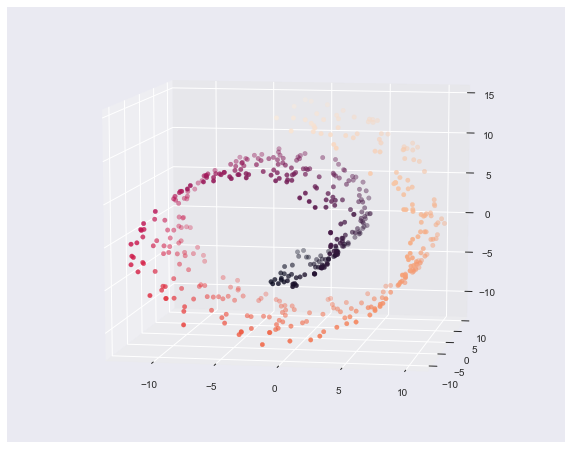

In [61]:
rcParams['figure.figsize'] = (10,8)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, -80)
ax.scatter(x[0,:], x[1,:], x[2,:], c=preprocessing.scale(t_true), marker='o')
plt.show()

# Model

In [4]:
#tinit = np.random.multivariate_normal([0] * Dt * N, np.identity(Dt * N)*.25).reshape((1,N))
tinit = np.random.uniform(-1.5, 1.5, size=(Dt,N))
Cinit = 0.1*np.random.randn(Dy,Dt*N)

#build nearest neighbor graph
G = neighbors.kneighbors_graph(x.T, 8, mode='connectivity')
G = G + G.T
G.data = np.ones_like(G.data)

# propose a better t_init by inferring order from graph structure
# First, get relative distances from arbitrary node
start_node = np.where(breadth_first_order(G,0)[0] == N - 1)[0][0]
# Second, get relative distances from furthest node
order_init, _ = breadth_first_order(G, start_node)
# Finally, assign t_init based on those distances
t_init = order_init.argsort().reshape(Dt, N).astype(np.float64)

#set user-defined parameters
alpha = 1.0
gamma =5.0
epsilon = .00001
V = np.cov(x) * gamma

model = LL_LVM(G,epsilon,alpha,V,Cinit,t_init,x,.01)

In [5]:
# orders
order_true = t_true.argsort()
#order_init = t_init[0,:].astype(int)
order_init0 = tinit[0,:].argsort()

# Time Path Plots

Text(0.5,0.92,'Path along $t_{true}$')

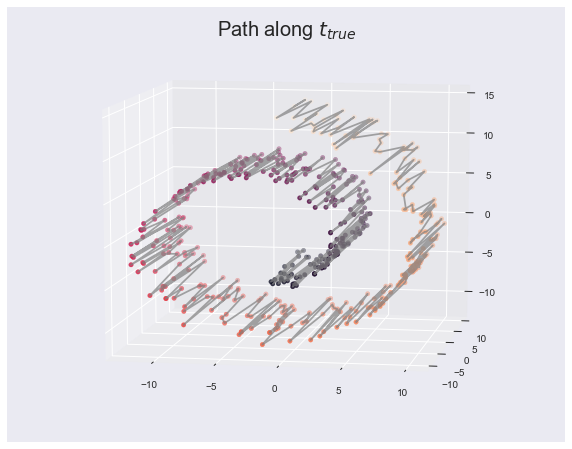

In [68]:
ax = plt.axes(projection='3d')
ax.view_init(10, -80)

# path along t
ax.plot3D(x[0,order_true],
          x[1,order_true], 
          x[2,order_true], 'gray', alpha=0.7)

# points colored by t_true value
ax.scatter3D(x[0,:], x[1,:], x[2,:], c=t_true, marker='o')
plt.title("Path along $t_{true}$", fontsize=20);

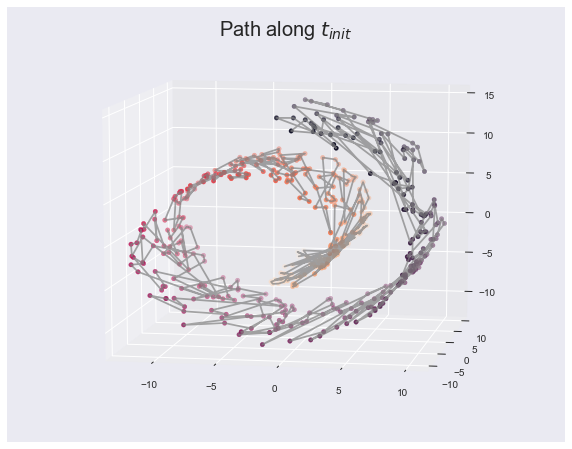

In [69]:
ax = plt.axes(projection='3d')
ax.view_init(10, -80)

# Path along t_init
ax.plot3D(x[0,order_init],
          x[1,order_init],
          x[2,order_init], 'gray', alpha=0.7)

# points colored by t_init value
ax.scatter3D(x[0,:], x[1,:], x[2,:], c=order_init.argsort(), marker='o')
plt.title("Path along $t_{init}$", fontsize=20);

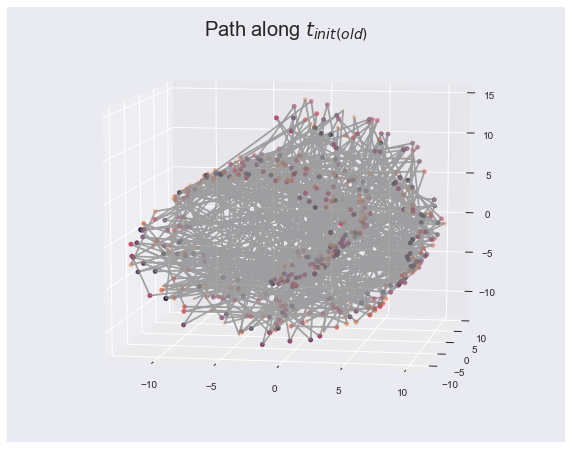

In [70]:
ax = plt.axes(projection='3d')
ax.view_init(10, -80)

# path along tinit
ax.plot3D(x[0,order_init0],
          x[1,order_init0], 
          x[2,order_init0], 'gray', alpha=0.7)

# points colored by tinit value
ax.scatter3D(x[0,:], x[1,:], x[2,:], c=order_init0.argsort(), marker='o')
plt.title("Path along $t_{init(old)}$", fontsize=20);

Text(0.5,1,'Comparison of $t$ to Graph-Inferred Estimate')

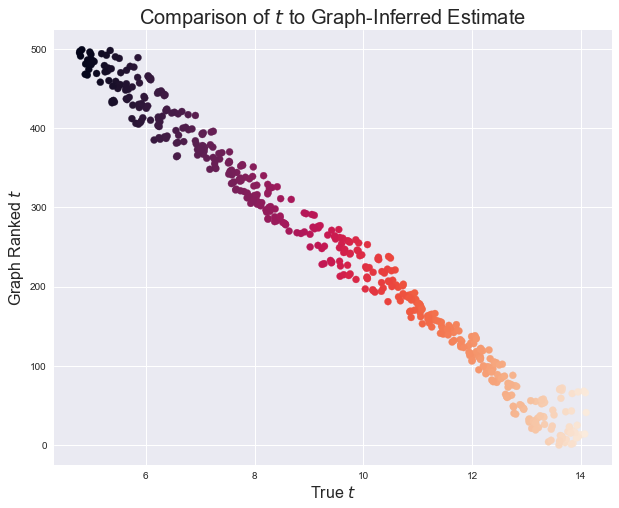

In [74]:
plt.scatter(t_true, t_init, c=t_true)
plt.xlabel("True $t$", fontsize=16)
plt.ylabel("Graph Ranked $t$", fontsize=16)
plt.title("Comparison of $t$ to Graph-Inferred Estimate", fontsize=20)

# Sampling

In [16]:
n_burn = 1000

for i in range(n_burn):
    print("\rStep %d of %d" % (i+1,n_burn), end="")
    model.MH_step(burn_in=True)

Step 1000 of 1000

In [17]:
n_samp = 10000

for i in range(n_samp):
    print("\rStep %d of %d" % (i+1,n_samp), end="")
    model.MH_step(burn_in=False)

Step 10000 of 10000

In [18]:
acceptance_rate = model.acceptance / (n_samp+n_burn)

print("Acceptance rate: %.8f" % acceptance_rate)

Acceptance rate: 0.50500000


# Likelihood Plot

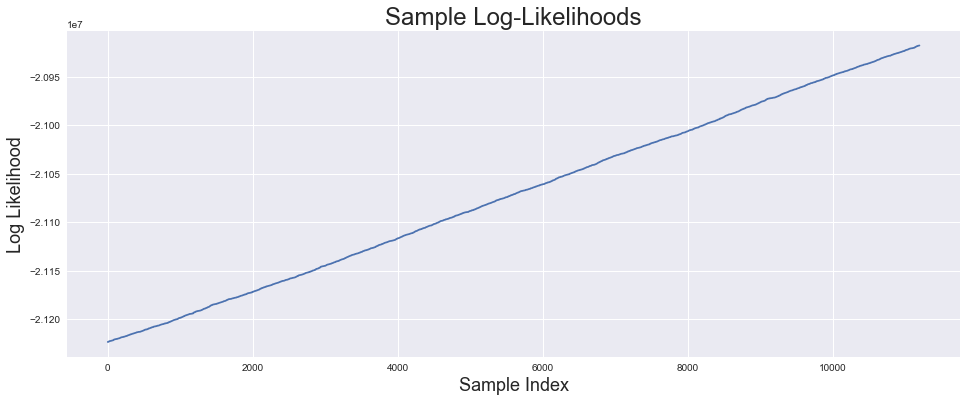

In [19]:
rcParams['figure.figsize'] = (16,6)
plt.plot(model.likelihoods)
plt.title("Sample Log-Likelihoods", fontsize=24)
plt.ylabel("Log Likelihood", fontsize=18)
plt.xlabel("Sample Index", fontsize=18);

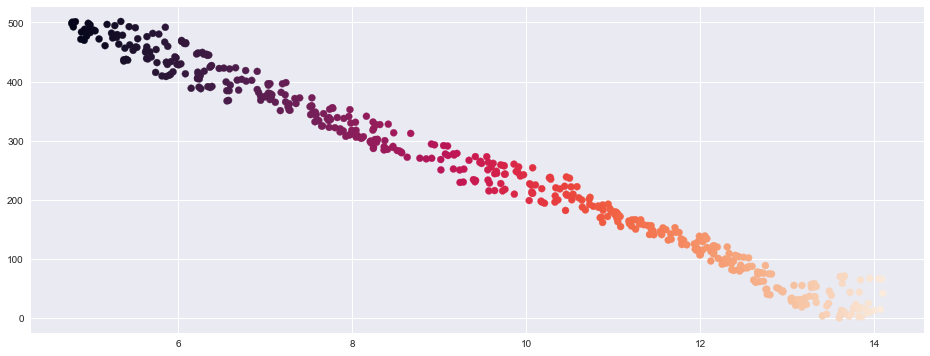

In [41]:
plt.scatter(t_true, model.tfinal / n_samp, c=t_true);

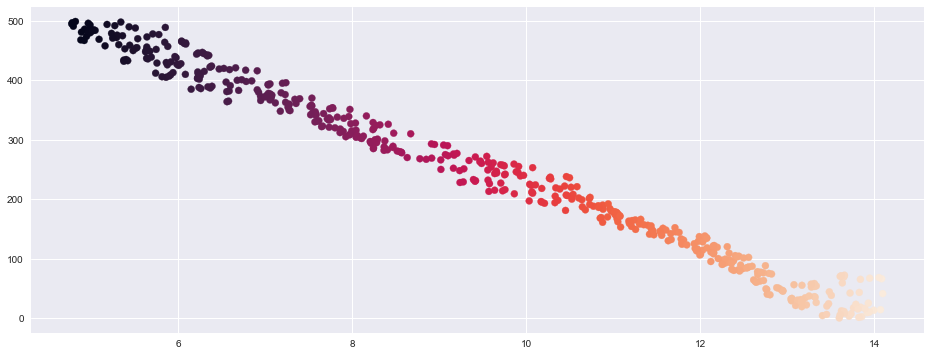

In [40]:
plt.scatter(t_true, t_init, c=t_true)

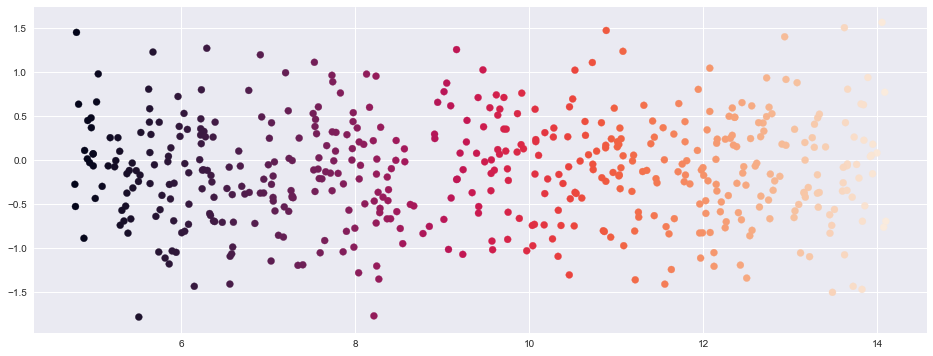

In [43]:
plt.scatter(t_true, t_init - model.tfinal / (n_samp+60), c=t_true)

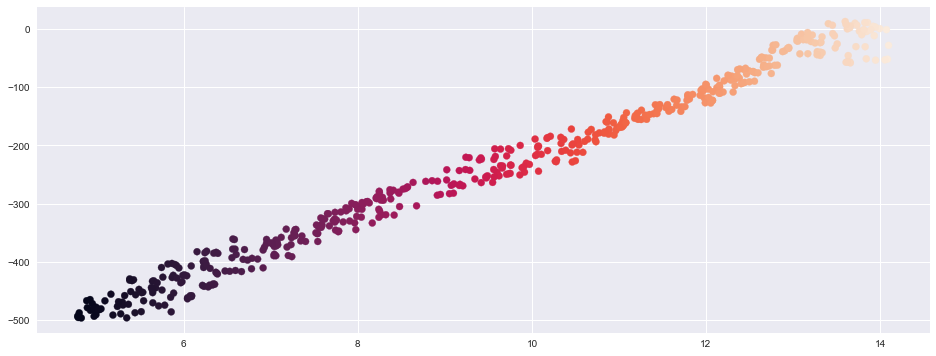

In [59]:
plt.scatter(t_true, t_true - model.tfinal / (n_samp), c=t_true)

## Version Information

In [10]:
%load_ext version_information
%version_information numpy, scipy, sklearn, matplotlib, version_information

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
IPython 6.2.1
OS Darwin 15.6.0 x86_64 i386 64bit
numpy 1.13.3
scipy 0.19.1
sklearn 0.19.1
matplotlib 2.1.0
version_information 1.0.3
Thu Nov 09 03:26:34 2017 EST